In [100]:
from imports.resources import Session
from imports.resources.db_classes import Transformer, Weights, Furfural, Load, Oil_Quality, Dissolved_Gases, Maintenance, Health_Index
from imports.resources.Mixins import MixinsTables
import pandas as pd
import numpy as np
import random

random.seed(1)

session = Session()

In [101]:
trs = Transformer()
trs_list = trs.get_batch(session)
transfs=[transf.id_transformer for transf in trs_list]
transfs

['SE6', 'SE8', 'SE9', 'SE2', 'SE3_TP3', 'SE3_TP4', 'SE5', 'SE4', 'SE1', 'SE7']

In [102]:
# Criar um dicionário com os nomes das tables relevantes e dos respetivos campos de dados que serão transpostos para o df final
tables={}
relationships=trs.__mapper__.relationships

for relation in relationships:
    
    classs = relation.entity.class_
    name = classs.__name__

    if name == 'Weights' or name == 'Health_Index': continue   #Depois incluir o Health Index!!!!!
    
    attrs = classs.__table__.columns.keys()
    attrs.remove(classs.__table__.primary_key.columns.keys()[0])
    attrs.remove('datestamp')
    attrs.remove('id_transformer')
    if name == 'Maintenance': attrs.remove('descript')
    if name == 'Health_Index': attrs.remove('id_algorithm')
    if name == 'Load': attrs.remove('power_factor')

    tables[name] = attrs

tables

{'Furfural': ['quantity'],
 'Load': ['load_factor'],
 'Oil_Quality': ['breakdown_voltage',
  'water_content',
  'acidity',
  'color',
  'interfacial_tension'],
 'Dissolved_Gases': ['h2', 'ch4', 'c2h6', 'c2h4', 'c2h2', 'co', 'coh2'],
 'Maintenance': ['impact_index']}

In [103]:
minyear, maxyear = 1990, 2020
rawdf={}

for trs_id in transfs:

    trs=Transformer(id_transformer=trs_id)

    # Inicializar dicionário pré-dataframe
    predf={}

    # inicializar vetores que vão constar no dicionário
    predf['year']=[]
    for table, attrs in tables.items():
        for attr in attrs:
            predf[attr]=[]

    for year in range(minyear, maxyear+1):
        predf['year'].append(year)
        dict_queries = trs.get_by_time_interval(session, mindate=str(year)+'-01-01', maxdate=str(year)+'-12-31')
        
        for table, attrs in tables.items():
            query = dict_queries[table]
            
            for attr in attrs:
                values = [getattr(measure,attr) for measure in query]
                if values:
                    predf[attr].append(np.mean(values))
                else:
                    predf[attr].append(np.nan)

    rawdf[trs_id] = pd.DataFrame(data=predf)

In [104]:
rawdf[transfs[0]]

,year,quantity,load_factor,breakdown_voltage,water_content,acidity,color,interfacial_tension,h2,ch4,c2h6,c2h4,c2h2,co,coh2,impact_index
0,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1994,NaN,NaN,89.4,7.8,0.044,6.0,21.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1996,NaN,NaN,46.6,9.2,0.100,5.5,20.7,15.0,3.0,13.0,17.0,3.0,157.0,3.60,NaN
7,1997,NaN,NaN,85.2,18.2,0.068,5.5,20.8,13.0,5.0,15.0,20.0,6.0,288.0,6.00,NaN
8,1998,0.00,NaN,89.1,12.9,0.060,5.5,20.9,21.2,8.2,16.7,27.1,13.4,455.4,9.40,NaN
9,1999,0.02,NaN,70.4,14.5,0.068,6.0,21.7,21.0,8.9,24.0,32.0,13.0,499.0,11.26,NaN


In [105]:
df = {}
for transf in transfs:
    df[transf] = rawdf[transf].interpolate(limit_area='inside')                            \
                                .dropna(thresh=2)                                           \
                                .interpolate(limit_area='outside', limit_direction='both')

In [115]:
df[transfs[0]]

,quantity,load_factor,breakdown_voltage,water_content,acidity,color,interfacial_tension,h2,ch4,c2h6,c2h4,c2h2,co,coh2,impact_index
6,1.016207,-0.554667,-0.071405,0.939522,-1.149588,-0.828184,0.881829,0.775739,0.746434,0.973050,-0.426213,-0.665289,-0.307459,-0.725551,-0.493668
7,1.016207,-0.554667,-0.071405,-0.103941,-1.149588,-0.828184,0.881829,0.641676,1.120661,1.329459,-0.383807,-0.492589,-0.163568,-0.600796,-0.493668
8,-0.198587,-0.554667,-0.180617,0.885316,-1.064496,-0.534669,0.837601,0.641676,1.819219,1.833523,-0.305354,-0.380334,0.706971,-0.268116,-0.493668
9,-0.198587,-0.554667,-0.126011,0.654941,-0.979404,-0.681427,0.970287,1.814733,2.368086,2.240848,-0.137848,0.224117,1.290808,0.782598,-0.493668
10,-0.333564,-0.554667,1.059721,-0.402074,-0.951040,-0.681427,0.749143,0.353439,1.095713,1.517847,-0.139968,0.517708,-0.389476,0.020206,-0.493668
11,-0.603519,-0.554667,0.786690,-0.442728,-1.064496,-0.534669,0.417428,0.517667,0.322309,1.232719,-0.237504,0.267292,-0.383001,0.096445,-0.493668
12,-0.603519,-0.554667,-0.399041,-1.418434,-0.284487,-0.534669,0.052541,1.341041,1.079080,1.587431,0.113765,2.005809,0.194001,0.562659,-0.493668
13,-0.738496,-0.554667,-0.867093,-0.009081,-0.015030,-0.534669,0.019369,3.765360,1.769322,1.736784,0.218368,3.185928,0.924246,-0.007517,-0.493668
14,-0.873473,-0.554667,-0.044102,-0.374971,-0.809220,-0.681427,-0.644062,0.547831,0.022927,0.779570,0.063584,1.692070,-0.672581,-0.384554,0.317304
15,0.206344,-0.554667,-1.163526,0.370360,0.070062,-0.387912,-0.069088,1.831491,0.796331,1.492389,0.004214,3.436343,1.450527,1.091713,-0.493668


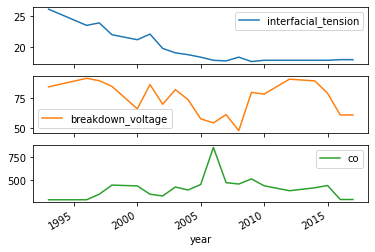

In [107]:
plot_features = df[transfs[6]][['interfacial_tension','breakdown_voltage','co']]
plot_features.index = df[transfs[6]]['year']
_ = plot_features.plot(subplots=True)

In [108]:
# Separating year from data
year={}
for trs in transfs:
    year[trs] = df[trs].pop('year')

In [109]:
# Train, Validation, Test split (0.6 / 0.2 / 0.2)
# Split is done by transformers

nr = len(transfs)
train_trs = transfs[:int(nr*0.6)]
valid_trs = transfs[int(nr*0.6):int(nr*0.8)]
test_trs  = transfs[int(nr*0.8):]

In [111]:
# Getting mean and std of training data and normalizing all data
train_df = pd.DataFrame()

for trs in train_trs:
    train_df = train_df.append(df[trs])

train_mean = train_df.mean()
train_std = train_df.std()

for trs in transfs:
    df[trs] = (df[trs]- train_mean) / train_std

In [114]:
df[transfs[0]]

,quantity,load_factor,breakdown_voltage,water_content,acidity,color,interfacial_tension,h2,ch4,c2h6,c2h4,c2h2,co,coh2,impact_index
6,1.016207,-0.554667,-0.071405,0.939522,-1.149588,-0.828184,0.881829,0.775739,0.746434,0.973050,-0.426213,-0.665289,-0.307459,-0.725551,-0.493668
7,1.016207,-0.554667,-0.071405,-0.103941,-1.149588,-0.828184,0.881829,0.641676,1.120661,1.329459,-0.383807,-0.492589,-0.163568,-0.600796,-0.493668
8,-0.198587,-0.554667,-0.180617,0.885316,-1.064496,-0.534669,0.837601,0.641676,1.819219,1.833523,-0.305354,-0.380334,0.706971,-0.268116,-0.493668
9,-0.198587,-0.554667,-0.126011,0.654941,-0.979404,-0.681427,0.970287,1.814733,2.368086,2.240848,-0.137848,0.224117,1.290808,0.782598,-0.493668
10,-0.333564,-0.554667,1.059721,-0.402074,-0.951040,-0.681427,0.749143,0.353439,1.095713,1.517847,-0.139968,0.517708,-0.389476,0.020206,-0.493668
11,-0.603519,-0.554667,0.786690,-0.442728,-1.064496,-0.534669,0.417428,0.517667,0.322309,1.232719,-0.237504,0.267292,-0.383001,0.096445,-0.493668
12,-0.603519,-0.554667,-0.399041,-1.418434,-0.284487,-0.534669,0.052541,1.341041,1.079080,1.587431,0.113765,2.005809,0.194001,0.562659,-0.493668
13,-0.738496,-0.554667,-0.867093,-0.009081,-0.015030,-0.534669,0.019369,3.765360,1.769322,1.736784,0.218368,3.185928,0.924246,-0.007517,-0.493668
14,-0.873473,-0.554667,-0.044102,-0.374971,-0.809220,-0.681427,-0.644062,0.547831,0.022927,0.779570,0.063584,1.692070,-0.672581,-0.384554,0.317304
15,0.206344,-0.554667,-1.163526,0.370360,0.070062,-0.387912,-0.069088,1.831491,0.796331,1.492389,0.004214,3.436343,1.450527,1.091713,-0.493668


In [120]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
        self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example